# Task 2: CNN with PyTorch
# CENG501 - Spring 2021 - PA2 - Berker Acır - 2098697

In this task, you will implement a convolutional neural network (CNN) with PyTorch. 


## 1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [ ]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import random                   # Python's random library

# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary


%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### 1.1 Enable GPU

From "Edit -> Notebook Settings -> Hardware accelerator" select GPU. With the following we will specify to PyTorch that we want to use the GPU.

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset. 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.1 Visualize Samples

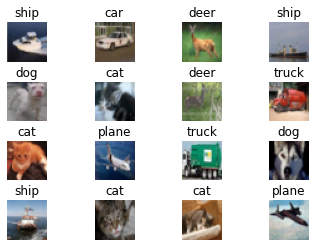

In [ ]:
dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = dataiter.next()
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 4 Define and Train a Small CNN Model

Now, all the pieces are ready and we can define a model.

### 4.1 Model Definition

Create a three-layer CNN with the following layers:

| Layer Name | Input HxW | Filter size | Stride | Pad | # of in channels | Out HxW | # of out channels | 
| ----| -----| ----| ---| ---| ----| -----|---------- |
| Conv1   | 32x32 | ? | ? | ? | 3  | 28x28 | 16 |
| Conv2   | 28x28 | ? | ? | ? | 16 | 26x26 | 32 |
| Maxpool | 26x26 | 4 | 2 | 0 | 32 | 12x12 | 32 |
| Conv3   | 12x12 | ? | ? | ? | 32 | 10x10 | 32 |

and the fully-connected layers:

| Layer Name | Input Size | Output size | 
| ----| -----| ----| 
| FC1 | 3200 | 1500 |
| FC2 | 1500 | 10 | 

While creating your model, pay attention to the following aspects:
* Each Conv layer and FC layer will be followed by ReLU, except for the last one.
* You should keep all other parameters (dilation, bias, group-mode, ..) as their default values in Pytorch.

You will need to read the following pages from Pytorch regarding the layers that you will use:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)       
        self.conv1 = None
        self.conv2 = None
        self.maxpool = None
        self.conv3 = None
        self.fc1 = None
        self.fc2 = None
        ###########################################################
        # @TODO: Create the convolutional and FC layers as        #
        #  described above.                                       #
        ###########################################################
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.fc1 = nn.Linear(3200, 1500)
        self.fc2 = nn.Linear(1500, 10)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers. Note that x    #
      # needs to be reshaped to (batchsize, 3200) before        #
      # the FC layers.                                          #
      ###########################################################
      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.maxpool(x)
      x = self.conv3(x)
      x = F.relu(x)
      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 4.2 Trainer for the Model

Let us define our training function, which will use the cuda device for training the model.

In [ ]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

### 4.3 Create and visualize the model

In [ ]:
model = SmallCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 --                        --
├─Conv2d: 1-1                            [128, 16, 28, 28]         1,216
├─Conv2d: 1-2                            [128, 32, 26, 26]         4,640
├─MaxPool2d: 1-3                         [128, 32, 12, 12]         --
├─Conv2d: 1-4                            [128, 32, 10, 10]         9,248
├─Linear: 1-5                            [128, 1500]               4,801,500
├─Linear: 1-6                            [128, 10]                 15,010
Total params: 4,831,614
Trainable params: 4,831,614
Non-trainable params: 0
Total mult-adds (G): 1.26
Input size (MB): 1.57
Forward/backward pass size (MB): 39.82
Params size (MB): 19.33
Estimated Total Size (MB): 60.72

### 4.4 Train the Small Model

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 2.252833938598633
Epoch 1 / 10: avg. loss of last 5 iterations 1.9602846384048462
Epoch 2 / 10: avg. loss of last 5 iterations 1.7500487089157104
Epoch 3 / 10: avg. loss of last 5 iterations 1.6033190488815308
Epoch 4 / 10: avg. loss of last 5 iterations 1.5140965700149536
Epoch 5 / 10: avg. loss of last 5 iterations 1.4129035711288451
Epoch 6 / 10: avg. loss of last 5 iterations 1.3084203481674195
Epoch 7 / 10: avg. loss of last 5 iterations 1.2826390743255616
Epoch 8 / 10: avg. loss of last 5 iterations 1.2921135187149049
Epoch 9 / 10: avg. loss of last 5 iterations 1.266666007041931


### 4.5 The Loss Curve

Let us visualize the loss curve.

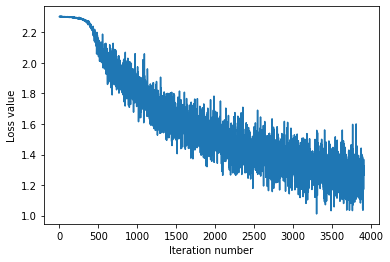

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 4.6 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 54\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


## 5 Your CNN

Now, create your own CNN. It should have at least 5 convolutional layers. Otherwise, there is no restriction on what you can use in your CNN or how you can structure it. 


### 5.1 Model Definition

YourCNN model is obtained from different model trials in **Section 5.1.1**.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class YourCNN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)       
        ###########################################################
        # @TODO: Create your layers here.                         #
        ###########################################################
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 8
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers.                #
      ###########################################################
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.batchNorm1(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = F.relu(self.conv2_3(x))
      x = self.batchNorm2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.batchNorm3(x)
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

#### 5.1.1 Other Model Definitions

SmallCNN model that we defined above achieves %54 accuracy. This section contains other models definitions that I tried to achieve the highest accuracy.

| Model Name | Accuracy |
| ---------- | -------- |
| SmallCNN   | 54%      |
| CNN1       | 41%      |
| CNN2       | 48%      |
| CNN3       | 50%      |
| CNN4       | 43%      |
| CNN5       | 44%      |
| CNN6       | 53%      |
| CNN7       | 53%      |
| CNN8       | 55%      |
| CNN8_SM    | 29%      |
| CNN8_D     | 52%      |
| CNN9       | 19%      |
| CNN9_BN1   | 75%      |
| CNN9_BN2   | 76%      |
| CNN10      | 10%      |
| **CNN10_BN1**  | 77%      |
| CNN10_BN1_D| 76%      |
| CNN10_BN2  | 76%      |
| CNN11_BN   | 74%      |
| CNN12_BN   | 74%      |
| CNN13_BN   | 73%      |
| CNN14_BN   | 73%      |

From the loss curves and accuracies of different models, I observed that 10 epochs were not enough for achieving great accuracies when I tried training deeper models with current configurations as the loss curves decrease after a while or do not decrease at all. Therefore, I thought that I could try training with different smaller models or better weight initialization methods in order to achieve better results. However, I could  achieve only 55% accuracy with using only convolution, pooling and fully connected layers. I did not play with the loss function and the optimizer.

I thought that batch normalization layers could be added to a deeper network instead of trying different weight initialization methods. Batch normalization layers increased the accuracy a lot when compared with the same model without batch normalization layers! As a result, I can say that batch normalization layers have great effect on training deeper convolutional neural networks.

I also tried different non-linear functions (sigmoid, tanh, softmax) at output of the models, but they seemed to decrease the models' accuracies. In addition to these methods, I tried using dropout method in fully connected layers. Yet, I didn't find that helpful neither.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=0)
        self.conv1_2 = nn.Conv2d(16, 16, 5, stride=1, padding=0)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2_1 = nn.Conv2d(16, 32, 3, stride=1, padding=0)
        self.conv2_2 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = self.maxPool2(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=0)
        self.conv1_2 = nn.Conv2d(16, 16, 5, stride=1, padding=0)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2_1 = nn.Conv2d(16, 32, 3, stride=1, padding=0)
        self.conv2_2 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=0)
        self.conv1_2 = nn.Conv2d(16, 32, 5, stride=1, padding=0)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2_1 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv2_2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.fc1 = nn.Linear(4096, 2048)
        self.fc2 = nn.Linear(2048, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN4(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=0)   #28
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  #28
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)  #28
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)      #14
        self.conv2_1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)  #14
        self.conv2_2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)  #14
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)  #12
        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = F.relu(self.conv2_3(x))

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN5(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)

        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=0)   #28
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=1, padding=0)  #26
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=0)  #24
        self.conv1_4 = nn.Conv2d(32, 32, 3, stride=1, padding=0)  #22
        self.conv1_5 = nn.Conv2d(32, 32, 3, stride=1, padding=0)  #20
        self.fc1 = nn.Linear(12800, 6000)
        self.fc2 = nn.Linear(6000, 2000)
        self.fc3 = nn.Linear(2000, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = F.relu(self.conv1_4(x))
      x = F.relu(self.conv1_5(x))

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN6(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=0)   # 28
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=1, padding=0)  # 26
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=0)  # 24
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)      # 12
        self.fc1 = nn.Linear(4608, 2000)
        self.fc2 = nn.Linear(2000, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.maxPool1(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN7(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)   # 32
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)  # 32
        self.conv1_3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  # 32
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)      # 16
        self.fc1 = nn.Linear(8192, 4000)
        self.fc2 = nn.Linear(4000, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.maxPool1(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN8(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)   # 32
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)  # 32
        self.conv1_3 = nn.Conv2d(16, 16, 3, stride=1, padding=1)  # 32
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)      # 16
        self.fc1 = nn.Linear(4096, 2000)
        self.fc2 = nn.Linear(2000, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.maxPool1(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN8_SM(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)   # 32
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)  # 32
        self.conv1_3 = nn.Conv2d(16, 16, 3, stride=1, padding=1)  # 32
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)      # 16
        self.fc1 = nn.Linear(4096, 2000)
        self.fc2 = nn.Linear(2000, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.maxPool1(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = F.softmax(self.fc2(x))
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN8_D(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)   # 32
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)  # 32
        self.conv1_3 = nn.Conv2d(16, 16, 3, stride=1, padding=1)  # 32
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)      # 16
        self.fc1 = nn.Linear(4096, 2000)
        self.fc2 = nn.Linear(2000, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.maxPool1(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, 0.5)
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN9(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 8
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN9_BN1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 8
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = self.batchNorm1(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = self.batchNorm2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = self.batchNorm3(x)
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN9_BN2(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)     # 32
        self.batchNorm1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.batchNorm1_2 = nn.BatchNorm2d(32)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2_2 = nn.BatchNorm2d(64)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 8
        self.batchNorm3_1 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.batchNorm3_2 = nn.BatchNorm2d(128)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = self.batchNorm1_1(x)
      x = F.relu(self.conv1_2(x))
      x = self.batchNorm1_2(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = self.batchNorm2_1(x)
      x = F.relu(self.conv2_2(x))
      x = self.batchNorm2_2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = self.batchNorm3_1(x)
      x = F.relu(self.conv3_2(x))
      x = self.batchNorm3_2(x)
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN10(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 8
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = F.relu(self.conv2_3(x))
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN10_BN1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 8
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.batchNorm1(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = F.relu(self.conv2_3(x))
      x = self.batchNorm2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.batchNorm3(x)
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN10_BN1_D(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 8
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.batchNorm1(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = F.relu(self.conv2_3(x))
      x = self.batchNorm2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.batchNorm3(x)
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, 0.5)
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN10_BN2(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)     # 32
        self.batchNorm1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.batchNorm1_2 = nn.BatchNorm2d(32)
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 32
        self.batchNorm1_3 = nn.BatchNorm2d(32)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2_2 = nn.BatchNorm2d(64)
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 16
        self.batchNorm2_3 = nn.BatchNorm2d(64)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 8
        self.batchNorm3_1 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.batchNorm3_2 = nn.BatchNorm2d(128)
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 8
        self.batchNorm3_3 = nn.BatchNorm2d(128)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = self.batchNorm1_1(x)
      x = F.relu(self.conv1_2(x))
      x = self.batchNorm1_2(x)
      x = F.relu(self.conv1_3(x))
      x = self.batchNorm1_3(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = self.batchNorm2_1(x)
      x = F.relu(self.conv2_2(x))
      x = self.batchNorm2_2(x)
      x = F.relu(self.conv2_3(x))
      x = self.batchNorm2_3(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = self.batchNorm3_1(x)
      x = F.relu(self.conv3_2(x))
      x = self.batchNorm3_2(x)
      x = F.relu(self.conv3_3(x))
      x = self.batchNorm3_2(x)
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN11_BN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)    # 32
        self.conv1_3 = nn.Conv2d(16, 16, 3, stride=1, padding=1)    # 32
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(16, 32, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 16
        self.conv2_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 16
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 8
        self.conv3_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 8
        self.conv3_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 8
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.batchNorm1(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = F.relu(self.conv2_3(x))
      x = self.batchNorm2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.batchNorm3(x)
      x = self.maxPool3(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN12_BN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)    # 32
        self.conv1_3 = nn.Conv2d(16, 16, 3, stride=1, padding=1)    # 32
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(16, 32, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 16
        self.conv2_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 16
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 8
        self.conv3_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 8
        self.conv3_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 8
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.conv4_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 4
        self.conv4_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 4
        self.conv4_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 4
        self.batchNorm4 = nn.BatchNorm2d(128)
        self.maxPool4 = nn.MaxPool2d(2, stride=2, padding=0)        # 2
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.batchNorm1(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = F.relu(self.conv2_3(x))
      x = self.batchNorm2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.batchNorm3(x)
      x = self.maxPool3(x)
      x = F.relu(self.conv4_1(x))
      x = F.relu(self.conv4_2(x))
      x = F.relu(self.conv4_3(x))
      x = self.batchNorm4(x)
      x = self.maxPool4(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN13_BN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)    # 32
        self.conv1_3 = nn.Conv2d(16, 16, 3, stride=1, padding=1)    # 32
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(16, 32, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 16
        self.conv2_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 16
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 8
        self.conv3_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 8
        self.conv3_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 8
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.conv4_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 4
        self.conv4_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 4
        self.conv4_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 4
        self.batchNorm4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = F.relu(self.conv1_3(x))
      x = self.batchNorm1(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = F.relu(self.conv2_3(x))
      x = self.batchNorm2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = F.relu(self.conv3_3(x))
      x = self.batchNorm3(x)
      x = self.maxPool3(x)
      x = F.relu(self.conv4_1(x))
      x = F.relu(self.conv4_2(x))
      x = F.relu(self.conv4_3(x))
      x = self.batchNorm4(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN14_BN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.conv1_1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)     # 32
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)    # 32
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.maxPool1 = nn.MaxPool2d(2, stride=2, padding=0)        # 16
        self.conv2_1 = nn.Conv2d(16, 32, 3, stride=1, padding=1)    # 16
        self.conv2_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)    # 16
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.maxPool2 = nn.MaxPool2d(2, stride=2, padding=0)        # 8
        self.conv3_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)    # 8
        self.conv3_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)    # 8
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.maxPool3 = nn.MaxPool2d(2, stride=2, padding=0)        # 4
        self.conv4_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)   # 4
        self.conv4_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 4
        self.batchNorm4 = nn.BatchNorm2d(128)
        self.maxPool4 = nn.MaxPool2d(2, stride=2, padding=0)        # 2
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = F.relu(self.conv1_1(x))
      x = F.relu(self.conv1_2(x))
      x = self.batchNorm1(x)
      x = self.maxPool1(x)
      x = F.relu(self.conv2_1(x))
      x = F.relu(self.conv2_2(x))
      x = self.batchNorm2(x)
      x = self.maxPool2(x)
      x = F.relu(self.conv3_1(x))
      x = F.relu(self.conv3_2(x))
      x = self.batchNorm3(x)
      x = self.maxPool3(x)
      x = F.relu(self.conv4_1(x))
      x = F.relu(self.conv4_2(x))
      x = self.batchNorm4(x)
      x = self.maxPool4(x)

      N, C, H, W = x.shape
      x = x.reshape(N, C*H*W)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

### 5.2 Create and visualize your model

In [ ]:
model = YourCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─Conv2d: 1-2                            [128, 32, 32, 32]         9,248
├─Conv2d: 1-3                            [128, 32, 32, 32]         9,248
├─BatchNorm2d: 1-4                       [128, 32, 32, 32]         64
├─MaxPool2d: 1-5                         [128, 32, 16, 16]         --
├─Conv2d: 1-6                            [128, 64, 16, 16]         18,496
├─Conv2d: 1-7                            [128, 64, 16, 16]         36,928
├─Conv2d: 1-8                            [128, 64, 16, 16]         36,928
├─BatchNorm2d: 1-9                       [128, 64, 16, 16]         128
├─MaxPool2d: 1-10                        [128, 64, 8, 8]           --
├─Conv2d: 1-11                           [128, 128, 8, 8]          73,856
├─Conv2d: 1-12                           [128, 128, 8, 8]    

### 5.3 Train the Model

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 20
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 20: avg. loss of last 5 iterations 0.005259325262159109
Epoch 1 / 20: avg. loss of last 5 iterations 0.003038365603424609
Epoch 2 / 20: avg. loss of last 5 iterations 0.002655094489455223
Epoch 3 / 20: avg. loss of last 5 iterations 0.0019203252159059048
Epoch 4 / 20: avg. loss of last 5 iterations 0.002279576053842902
Epoch 5 / 20: avg. loss of last 5 iterations 0.0019747259793803096
Epoch 6 / 20: avg. loss of last 5 iterations 0.0014641058631241321
Epoch 7 / 20: avg. loss of last 5 iterations 0.001306348037905991
Epoch 8 / 20: avg. loss of last 5 iterations 0.0013142011826857924
Epoch 9 / 20: avg. loss of last 5 iterations 0.0008864669129252434
Epoch 10 / 20: avg. loss of last 5 iterations 0.0010287533630616962
Epoch 11 / 20: avg. loss of last 5 iterations 0.0012165225110948087
Epoch 12 / 20: avg. loss of last 5 iterations 0.001024362281896174
Epoch 13 / 20: avg. loss of last 5 iterations 0.00126067049568519
Epoch 14 / 20: avg. loss of last 5 iterations 0.000770467298571020

### 5.4 Loss Curve

Let us visualize the loss curve.

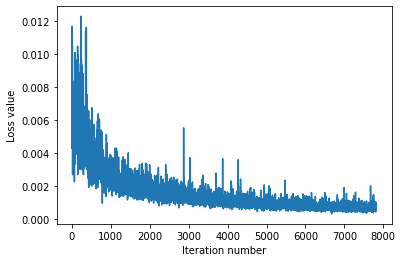

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 5.5 Quantitative Analysis

Analyze your model quantitatively.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct/total))

Accuracy of the network on the 10000 test images: 78 %


YourCNN model achives 76% accuracy whereas our SmallCNN achieves only %54. When I increased the epoch to 20 the accuracy was increased to 78%. In order to improve the model, I tried to following methods *(related models and their accuracies can be found in **Section 5.1.1**)*:

*   Increased the convolutional layer number
*   Different combinations of convolutional layers with max-pooling layers
*   Different channel numbers and filter sizes with different stride and padding parameters
*   Different activation functions such as *tanh*, *sigmoid* and *softmax*
*   Dropout
*   **Batch Normalization**

I thought that increasing the depth of the model would increase the accuracy. However, it was not the case because the loss would start to decrease after while. 10 epochs were not enough for training that models. Combination of different channel numbers, convolutional and pooling layer numbers with different filter sizes, strides and paddings didn't improve much. Using different functions for output of the model (i.e. output of the last fully connected layer) also did not improve the accuracy. However, using batch normalization layers in deeper networks enabled the models to achieve better results. For example, my *CNN10* model achieved 10% accuracy whereas the same model with batch normalization layers (*CNN10_BN1* or *CNN10_BN2*) achieved 76% accuracy. Batch normalization definitely results in better learning process.
